# Adversarial VAE detection on MNIST

## Method

The adversarial VAE detector is first trained on a batch of unlabeled but normal (*not adversarial*) data. The loss is however different from traditional VAE training and focuses on minimizing the KL-divergence between a classifier's predictions on the original and reconstructed data. When an adversarial instance is fed to the VAE, the KL-divergence between the predictions on the adversarial example and the reconstruction is large. The reconstruction does not contain the adversarial artefacts and has a very different prediction distribution. As a result, the adversarial instance is flagged.

## Dataset

traffic signs

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from PIL import Image
import os
import zipfile
import logging

from tensorflow.keras.layers import Activation, Conv2D, Conv2DTranspose, Dense, Dropout
from tensorflow.keras.layers import Flatten, Input, InputLayer, Reshape, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
# Adversarial attack method. The latest release of the `cleverhans` package does
# not support TensrFlow 2 yet, so we need to install from the master branch:
# pip install git+https://github.com/tensorflow/cleverhans.git#egg=cleverhans
from cleverhans.future.tf2.attacks import projected_gradient_descent

import alibi_detect.ad as adv
from alibi_detect.datasets import fetch_traffic_signs
from alibi_detect.models.losses import loss_adv_vae
from alibi_detect.ad import AdversarialVAE
from alibi_detect.utils.saving import save_detector, load_detector, save_tf_model, load_tf_model
from alibi_detect.utils.visualize import plot_instance_score

tf.keras.backend.clear_session()
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

import json

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [2]:
from inspect import signature
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import precision_score, recall_score, accuracy_score, precision_recall_curve, f1_score
import matplotlib
import seaborn as sns
from creme.stats import Mean, Var
%matplotlib inline
from scipy.stats import percentileofscore
from importlib import reload

# Load traffic signs data

In [3]:
#!gsutil cp gs://seldon-datasets/traffic/
#!mv 'gtsrb-german-traffic-sign.zip' ../data/traffic/.

In [4]:
log_dir = '/home/gio/experiments/signs/model_0/vae_0/'
data_dir = '/'.join(log_dir.split('/')[:-3]) + '/'
model_dir = '/'.join(log_dir.split('/')[:-2]) + '/'
detector_dir = '/'.join(log_dir.split('/')[:-1]) + '/'

In [5]:
bunch = fetch_traffic_signs(data_folder='../data/traffic/')
X_train, y_train = bunch.train
X_val, y_val = bunch.val
X_test, y_test = bunch.test

X_train = X_train.reshape(-1, 32, 32, 3).astype('float32') / 255
X_val = X_val.reshape(-1, 32, 32, 3).astype('float32') / 255
X_test = X_test.reshape(-1, 32, 32, 3).astype('float32') / 255
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)
y_test = to_categorical(y_test, 43)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
#classes = ('0', '1', '2', '3',
#           '4', '5', '6', '7', '8', '9')
img_shape = (28, 28)


INFO:alibi_detect.datasets:Unzipping file ...
INFO:alibi_detect.datasets:Extracting images


/tmp/tmp6hv7v0w9/train/0/
/tmp/tmp6hv7v0w9/train/1/
/tmp/tmp6hv7v0w9/train/2/
/tmp/tmp6hv7v0w9/train/3/
/tmp/tmp6hv7v0w9/train/4/
/tmp/tmp6hv7v0w9/train/5/
/tmp/tmp6hv7v0w9/train/6/
/tmp/tmp6hv7v0w9/train/7/
/tmp/tmp6hv7v0w9/train/8/
/tmp/tmp6hv7v0w9/train/9/
/tmp/tmp6hv7v0w9/train/10/
/tmp/tmp6hv7v0w9/train/11/
/tmp/tmp6hv7v0w9/train/12/
/tmp/tmp6hv7v0w9/train/13/
/tmp/tmp6hv7v0w9/train/14/
/tmp/tmp6hv7v0w9/train/15/
/tmp/tmp6hv7v0w9/train/16/
/tmp/tmp6hv7v0w9/train/17/
/tmp/tmp6hv7v0w9/train/18/
/tmp/tmp6hv7v0w9/train/19/
/tmp/tmp6hv7v0w9/train/20/
/tmp/tmp6hv7v0w9/train/21/
/tmp/tmp6hv7v0w9/train/22/
/tmp/tmp6hv7v0w9/train/23/
/tmp/tmp6hv7v0w9/train/24/
/tmp/tmp6hv7v0w9/train/25/
/tmp/tmp6hv7v0w9/train/26/
/tmp/tmp6hv7v0w9/train/27/
/tmp/tmp6hv7v0w9/train/28/
/tmp/tmp6hv7v0w9/train/29/
/tmp/tmp6hv7v0w9/train/30/
/tmp/tmp6hv7v0w9/train/31/
/tmp/tmp6hv7v0w9/train/32/
/tmp/tmp6hv7v0w9/train/33/
/tmp/tmp6hv7v0w9/train/34/
/tmp/tmp6hv7v0w9/train/35/
/tmp/tmp6hv7v0w9/train/36/
/tmp/tmp6hv

### Show example

Sample instance from the signs data set.


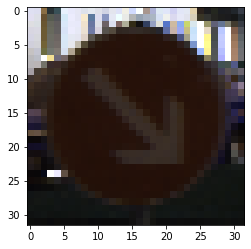

In [6]:
idx = 4200
x = X_train[idx: idx + 1]
plt.imshow(np.squeeze(x))
print('Sample instance from the signs data set.')

## Create and train traffic signs model

The pretrained outlier and adversarial detectors used in the example notebooks can be found [here](https://console.cloud.google.com/storage/browser/seldon-models/alibi-detect). You can either manually download the relevant files in the [model_mnist](https://console.cloud.google.com/storage/browser/seldon-models/alibi-detect/model_mnist/) folder to e.g. the local directory ```my_dir```. Alternatively,  if you have [Google Cloud SDK](https://cloud.google.com/sdk/docs/) installed, you can download the whole folder as follows:

```bash
!gsutil cp -r gs://seldon-models/alibi-detect/model_mnist my_dir
```

In [7]:
load_signs_model = False

In [8]:
filepath = model_dir
if load_signs_model:
    model = load_tf_model(filepath)
else:
    # define model
    inputs = Input(shape=(X_train.shape[1:]))
    x = Conv2D(64, 5, padding='same', activation='relu')(inputs)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(.3)(x)
    
    x = Conv2D(32, 3, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(.3)(x)
    
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(.5)(x)
    logits = Dense(43, name='logits')(x)
    outputs = Activation('softmax', name='softmax')(logits)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    
    #inputs = Input(shape=(X_train.shape[1:]))
    #x = Conv2D(filters=32, kernel_size=(5, 5), strides=1, padding='same', activation='relu')(inputs)
    #x = Conv2D(filters=64, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(x)
    #x = MaxPooling2D(pool_size=(2, 2))(x)
    #x = Dropout(0.25)(x)
    #
    #x = Conv2D(filters=64, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(x)
    #x = MaxPooling2D(pool_size=(2, 2))(x)
    #x = Dropout(0.25)(x)
    
    #x = Flatten()(x)
    #x = Dense(256, activation='relu')(x)
    #x = Dropout(0.5)(x)
    #logits = Dense(43, name='logits')(x)
    #outputs = Activation('softmax', name='softmax')(logits)
    #model = Model(inputs=inputs, outputs=outputs)
    #model.compile(loss='categorical_crossentropy',
    #              optimizer='adam',
    #              metrics=['accuracy'])
    
    # train model
    model.fit(X_train,
              y_train,
              epochs=20,
              batch_size=256,
              verbose=1,
              validation_data=(X_val, y_val)
              )
    
    # save model
    save_tf_model(model, filepath)

Train on 23527 samples, validate on 7841 samples
Epoch 1/20
23527/23527 [==============================] - 3s 131us/sample - loss: 2.9531 - accuracy: 0.2276 - val_loss: 1.7737 - val_accuracy: 0.5117
Epoch 2/20
23527/23527 [==============================] - 1s 47us/sample - loss: 1.5207 - accuracy: 0.5500 - val_loss: 0.8154 - val_accuracy: 0.7805
Epoch 3/20
23527/23527 [==============================] - 1s 47us/sample - loss: 0.9272 - accuracy: 0.7136 - val_loss: 0.5265 - val_accuracy: 0.8767
Epoch 4/20
23527/23527 [==============================] - 1s 47us/sample - loss: 0.6607 - accuracy: 0.7914 - val_loss: 0.3386 - val_accuracy: 0.9151
Epoch 5/20
23527/23527 [==============================] - 1s 47us/sample - loss: 0.5038 - accuracy: 0.8407 - val_loss: 0.2471 - val_accuracy: 0.9411
Epoch 6/20
23527/23527 [==============================] - 1s 47us/sample - loss: 0.4190 - accuracy: 0.8687 - val_loss: 0.2051 - val_accuracy: 0.9552
Epoch 7/20
23527/23527 [==============================] 

In [9]:
# evaluate model
results = model.evaluate(X_val, y_val, batch_size=256, verbose=0)
print('Test loss: {:.4f} -- accuracy: {:.4f}'.format(results[0], results[1]))

Test loss: 0.0497 -- accuracy: 0.9902


In [10]:
# evaluate model
results = model.evaluate(X_test, y_test, batch_size=256, verbose=0)
print('Test loss: {:.4f} -- accuracy: {:.4f}'.format(results[0], results[1]))

Test loss: 0.0505 -- accuracy: 0.9901


In [11]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 32)          0     

In [12]:
probs = model(X_test).numpy()

In [13]:
probs.shape

(7841, 43)

In [14]:
probs.max(axis=1).mean()

0.9731491

## Generate adversarial instances

The `cleverhans` adversarial attack methods assume that the model outputs logits, so we will create a modified model by simply removing the softmax output layer:

In [15]:
model_logits = Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [16]:
nb_adv = 1000
ids = np.arange(nb_adv)
np.random.shuffle(ids)
X_to_adv = X_val[ids]
y_adv = y_val[ids]
print(X_to_adv.shape)

(1000, 32, 32, 3)


In [17]:
X_adv = projected_gradient_descent(model_logits, None, 0,
                                   X_to_adv,
                                   eps=2.,
                                   eps_iter=1.,
                                   nb_iter=10,
                                   norm=2,
                                   clip_min=X_train.min(),
                                   clip_max=X_train.max(),
                                   rand_init=None,
                                   rand_minmax=.3,
                                   targeted=False,
                                   sanity_checks=False
                                  ).numpy()

In [18]:
y_pred = np.argmax(model(X_to_adv).numpy(), axis=-1)
y_pred_adv = np.argmax(model(X_adv).numpy(), axis=-1)
X_to_adv = X_to_adv[(y_pred != y_pred_adv)]
X_adv = X_adv[(y_pred != y_pred_adv)]

y_val = np.concatenate((np.zeros(len(X_to_adv)), np.ones(len(X_adv))))
X_val = np.concatenate([X_to_adv, X_adv], axis=0)
print(X_val.shape, y_val.shape)

(1820, 32, 32, 3) (1820,)


In [19]:
def advesarial_accuracy(ground_truth_val, preds_val):
    score_val = preds_val['data']['instance_score']
    preds_val = preds_val['data']['is_adversarial']

    acc = accuracy_score(ground_truth_val, preds_val)

    return acc

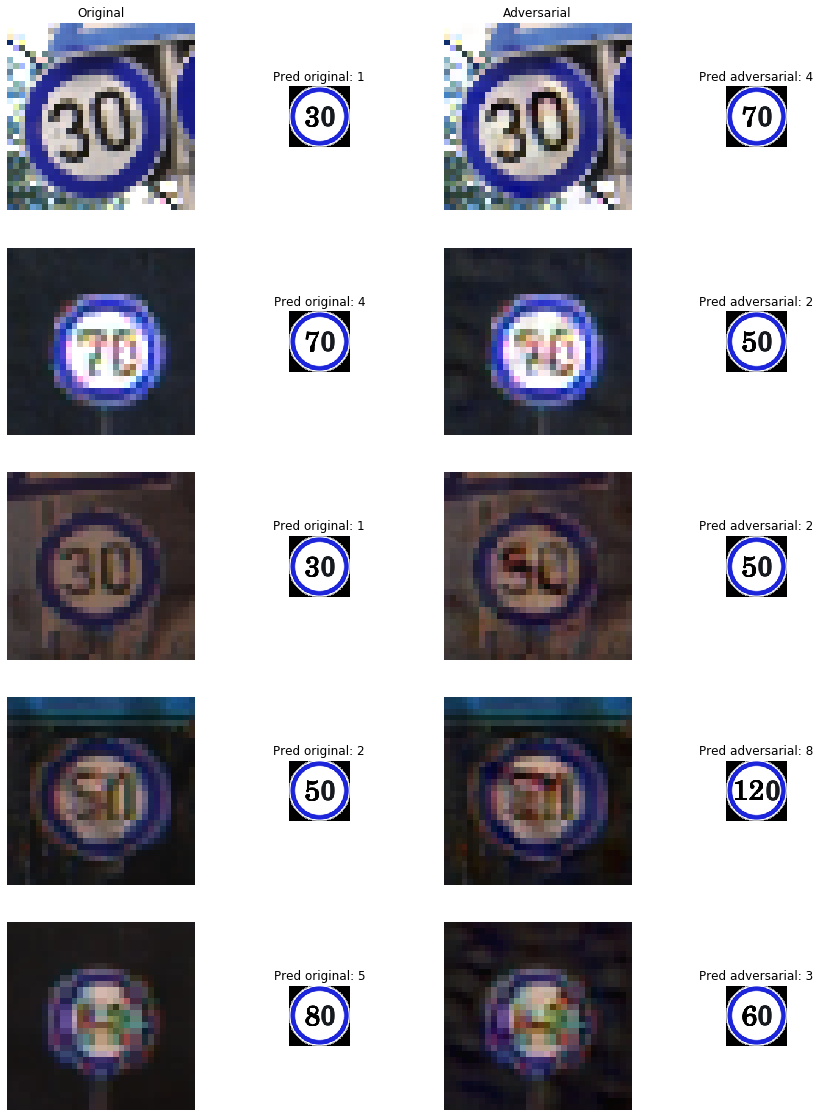

In [20]:
y_pred = np.argmax(model(X_to_adv).numpy(), axis=-1)
y_pred_adv = np.argmax(model(X_adv).numpy(), axis=-1)
meta_folder="../data/traffic/meta/"

n_rows = 5
n_cols = 4
figsize = (15, 20)
img_shape = (32, 32, 3)

fig5 = plt.figure(constrained_layout=False, figsize=figsize)
widths = [5, 1, 5, 1]
heights = [5, 5, 5, 5, 5]
spec5 = fig5.add_gridspec(ncols=4, nrows=5, width_ratios=widths,
                          height_ratios=heights)

for row in range(n_rows):
    ax_0 = fig5.add_subplot(spec5[row, 0])    
    ax_0.imshow(X_to_adv[row].reshape(img_shape))
    if row == 0:
        ax_0.title.set_text('Original')
    ax_0.axis('off')
    
    ax_1 = fig5.add_subplot(spec5[row, 1])
    class_image=cv2.imread(meta_folder+"{}.png".format(y_pred[row]))
    image = Image.fromarray(class_image, 'RGB')
    image = np.array(image)
    ax_1.imshow(image)
    ax_1.title.set_text('Pred original: {}'.format(y_pred[row]))
    ax_1.axis('off')
    
    ax_2 = fig5.add_subplot(spec5[row, 2])
    ax_2.imshow(X_adv[row].reshape(img_shape))
    if row == 0:
        ax_2.title.set_text('Adversarial')
    ax_2.axis('off')
    
    ax_3 = fig5.add_subplot(spec5[row, 3])
    class_image_adv=cv2.imread(meta_folder+"{}.png".format(y_pred_adv[row]))
    image_adv = Image.fromarray(class_image_adv, 'RGB')
    image_adv = np.array(image_adv)   
    ax_3.imshow(image_adv)
    ax_3.title.set_text('Pred adversarial: {}'.format(y_pred_adv[row]))
    ax_3.axis('off')
        #label = 'Width: {}\nHeight: {}'.format(widths[col], heights[row])
        #ax.annotate(label, (0.1, 0.5), xycoords='axes fraction', va='center')

## Train Adversarial VAE for MNIST

You can again either manually download the relevant files in the [ad_vae_mnist](https://console.cloud.google.com/storage/browser/seldon-models/alibi-detect/ad_vae_mnist/) folder to e.g. the local directory ```my_dir``` or use ```gsutil```:

```bash
!gsutil cp -r gs://seldon-models/alibi-detect/ad_vae_mnist my_dir
```

In [21]:
load_adversarial_detector = False

In [22]:
#encoder_net = tf.keras.Sequential(
#    [
#        InputLayer(input_shape=(32, 32, 3)),
#        Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu'),
#        #x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(x)
#        MaxPooling2D(pool_size=(2, 2)),
#        Dropout(0.25),
#        Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
#        MaxPooling2D(pool_size=(2, 2)),
#        Dropout(0.25)
#    ]
#)

In [59]:
log_dir = '/home/gio/experiments/signs/model_0/vae_1conv_1conv/'
data_dir = '/'.join(log_dir.split('/')[:-3]) + '/'
model_dir = '/'.join(log_dir.split('/')[:-2]) + '/'
detector_dir = '/'.join(log_dir.split('/')[:-1]) + '/'

filepath = detector_dir # change to directory where model is downloaded
if load_adversarial_detector:  # load pretrained adversarial detector
    ad = load_detector(filepath)
else:  # define model, initialize, train and save adversarial detector
    """
    # 1-layer model vae_1conv_1conv
    encoder_params = {'nb_filters_1': 64, 
               'kernel_1': 4, 
               'activation_1': 'relu',
                'padding_1': 'same',}
    decoder_params = {'nb_filters_1': 64, 
               'kernel_1': 3, 
               'activation_1': 'relu', 
               'padding_1': 'same', }
    vae_params = {'latent_dim': 40, 'optimizer': 'Adam'}
    
    latent_dim = vae_params['latent_dim']
    
    encoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(32, 32, 3)),
          Conv2D(encoder_params['nb_filters_1'], encoder_params['kernel_1'], strides=2, 
                 padding=encoder_params['padding_1'], activation=encoder_params['activation_1']),
      ])
    
    decoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(latent_dim,)),
          Dense(16*16*32, activation=tf.nn.relu),
          Reshape(target_shape=(16, 16, 32)),
          Conv2DTranspose(decoder_params['nb_filters_1'], decoder_params['kernel_1'], strides=1, 
                         padding=decoder_params['padding_1'], activation=decoder_params['activation_1']),
          Conv2DTranspose(3, 3, strides=2, 
                          padding='same', activation='sigmoid')
      ])
     
    ##############################################################################################################
    # 2-layer model vae_2conv_1conv
    encoder_params = {'nb_filters_1': 32, 'nb_filters_2': 64,
                      'kernel_1': 4, 'kernel_2': 4,
                      'activation_1': 'relu', 'activation_2': 'relu',
                      'padding_1': 'same', 'padding_2': 'same',
                      'dropout': True}
    decoder_params = {'nb_filters_1': 64, 'kernel_1': 3, 'activation_1': 'relu', 'padding_1': 'same', 
                     'dropout': True}
    vae_params = {'latent_dim': 40, 'optimizer': 'Adam'}
    
    latent_dim = vae_params['latent_dim']
    
    if not encoder_params['dropout']:
        encoder_net = tf.keras.Sequential(
            [
                InputLayer(input_shape=(32, 32, 3)),
                Conv2D(encoder_params['nb_filters_1'], encoder_params['kernel_1'], strides=2, 
                 padding=encoder_params['padding_1'], activation=encoder_params['activation_1']),
                Conv2D(encoder_params['nb_filters_2'], encoder_params['kernel_2'], strides=2, 
                 padding=encoder_params['padding_1'], activation=encoder_params['activation_2'])
              ])
    else:
        encoder_net = tf.keras.Sequential(
            [
                InputLayer(input_shape=(32, 32, 3)),
                Conv2D(encoder_params['nb_filters_1'], encoder_params['kernel_1'], strides=2,
                       padding=encoder_params['padding_1'], activation=encoder_params['activation_1']),
                Dropout(0.2),
                Conv2D(encoder_params['nb_filters_2'], encoder_params['kernel_2'], strides=2, 
                       padding=encoder_params['padding_1'], activation=encoder_params['activation_2']),
                Dropout(0.2)
              ])
        
    if not decoder_params['dropout']:    
        decoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(latent_dim,)),
          Dense(16*16*32, activation=tf.nn.relu),
          Reshape(target_shape=(16, 16, 32)),
          Conv2DTranspose(decoder_params['nb_filters_1'], decoder_params['kernel_1'], strides=1, 
                         padding=decoder_params['padding_1'], activation=decoder_params['activation_1']),
          Conv2DTranspose(3, 3, strides=2, 
                          padding='same', activation='sigmoid')
      ])
    else:
        decoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(latent_dim,)),
          Dense(16*16*32, activation=tf.nn.relu),
          Dropout(0.2),
          Reshape(target_shape=(16, 16, 32)),
          Conv2DTranspose(decoder_params['nb_filters_1'], decoder_params['kernel_1'], strides=1, 
                         padding=decoder_params['padding_1'], activation=decoder_params['activation_1']),
          Dropout(0.2),
          Conv2DTranspose(3, 3, strides=2, 
                          padding='same', activation='sigmoid')
      ])
    
    """
    ##########################################################################################################
    # 3-layers model (vae_0)
    encoder_params = {'nb_filters_1': 64, 'nb_filters_2': 32, 'nb_filters_3': 256,
               'kernel_1': 4, 'kernel_2': 4, 'kernel_3': 4,
               'activation_1': 'relu', 'activation_2': 'relu', 'activation_3': 'relu',
                'padding_1': 'same', 'padding_2': 'same', 'padding_3': 'same',
                'dropout': False,
                'dropout_1': 0.8, 'dropout_2': 0.8, 'dropout_3': 0.8}
    decoder_params = {'nb_filters_1': 32, 'nb_filters_2': 64, 'nb_filters_3': 3,
               'kernel_1': 3, 'kernel_2': 3, 'kernel_3': 3, 
               'activation_1': 'relu', 'activation_2': 'relu', 'activation_3': 'sigmoid',
               'padding_1': 'same', 'padding_2': 'same', 'padding_3': 'same',
                'dropout': False,
                'dropout_1': 0.2, 'dropout_2': 0.2, 'dropout_3': 0.2}
    vae_params = {'latent_dim': 430, 'optimizer': 'Adam'}
    
    latent_dim = vae_params['latent_dim']
    
    if not encoder_params['dropout']:
        encoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(32, 32, 3)),
          Conv2D(encoder_params['nb_filters_1'], encoder_params['kernel_1'], strides=2, 
                 padding=encoder_params['padding_1'], activation=encoder_params['activation_1']),
          Conv2D(encoder_params['nb_filters_2'], encoder_params['kernel_2'], strides=2, 
                 padding=encoder_params['padding_2'], activation=encoder_params['activation_2']),
          Conv2D(encoder_params['nb_filters_3'], encoder_params['kernel_3'], strides=2, 
                 padding=encoder_params['padding_3'], activation=encoder_params['activation_3'])
      ])
    
    else:
        print('encoder 800A')
        encoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(32, 32, 3)),
          Conv2D(encoder_params['nb_filters_1'], encoder_params['kernel_1'], strides=2, 
                 padding=encoder_params['padding_1'], activation=encoder_params['activation_1']),
          Dropout(encoder_params['dropout_1']),
          Conv2D(encoder_params['nb_filters_2'], encoder_params['kernel_2'], strides=2, 
                 padding=encoder_params['padding_2'], activation=encoder_params['activation_2']),
          Dropout(encoder_params['dropout_2']),
          Conv2D(encoder_params['nb_filters_3'], encoder_params['kernel_3'], strides=2, 
                 padding=encoder_params['padding_3'], activation=encoder_params['activation_3']),
          Dropout(encoder_params['dropout_3']),
      ])        
    
    if not decoder_params['dropout']:
        decoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(latent_dim,)),
          Dense(8*8*32, activation=tf.nn.relu),
          Reshape(target_shape=(8, 8, 32)),
          Conv2DTranspose(decoder_params['nb_filters_1'], decoder_params['kernel_1'], strides=2, 
                         padding=decoder_params['padding_1'], activation=decoder_params['activation_1']),
          Conv2DTranspose(decoder_params['nb_filters_2'], decoder_params['kernel_2'], strides=2, 
                          padding=decoder_params['padding_2'], activation=decoder_params['activation_2']),
          Conv2DTranspose(decoder_params['nb_filters_3'], decoder_params['kernel_3'], strides=1, 
                          padding=decoder_params['padding_3'], activation=decoder_params['activation_3'])
      ])
    else:
        print('decoder 800A')
        decoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(latent_dim,)),
          Dense(8*8*32, activation=tf.nn.relu),
          Dropout(decoder_params['dropout_1']),
          Reshape(target_shape=(8, 8, 32)),
          Conv2DTranspose(decoder_params['nb_filters_1'], decoder_params['kernel_1'], strides=2, 
                         padding=decoder_params['padding_1'], activation=decoder_params['activation_1']),
          Dropout(decoder_params['dropout_2']),
          Conv2DTranspose(decoder_params['nb_filters_2'], decoder_params['kernel_2'], strides=2, 
                          padding=decoder_params['padding_2'], activation=decoder_params['activation_2']),
          Dropout(decoder_params['dropout_3']),
          Conv2DTranspose(decoder_params['nb_filters_3'], decoder_params['kernel_3'], strides=1, 
                          padding=decoder_params['padding_3'], activation=decoder_params['activation_3'])
      ])
    
    runs = next(os.walk(log_dir))[1]
    run_id = 0
    while str(run_id) in runs:
        run_id += 1
        if run_id > 100:
            break
    run_dir = log_dir + str(run_id)
    print('Creating log dir:', run_dir)
    if not os.path.exists(run_dir):
        os.makedirs(run_dir)
    
    # initialize adversarial detector
    ad = adv.AdversarialVAE(threshold=.5,  # threshold for adversarial score
                        model=model,
                        encoder_net=encoder_net,  # can also pass VAE model instead
                        decoder_net=decoder_net,  # of separate encoder and decoder
                        latent_dim=latent_dim,
                        samples=2,  # nb of samples drawn by VAE
                        beta=0.  # weight on KL-divergence loss term of latent space
                       )
    
    if vae_params['optimizer'] == 'Adam':
        opt = Adam()
    elif vae_params['optimizer'] == 'Nadam':
        opt = Nadam()
    elif vae_params['optimizer'] == 'RMSprop':
        opt = RMSprop()
    elif vae_params['optimizer'] == 'SGD':
        opt = SGD(momentum=0.9)
    
    # train
    ad.fit(X_train,
           validation_data=(X_test[:1000], None),
           adversarial_data=(X_val, y_val),
           loss_fn=loss_adv_vae,
           w_model=1.,  # weight on KL-divergence loss term of model predictions
           w_recon=0.,  # weight on elbo loss term
           optimizer=opt,
           epochs=50,
           verbose=True,
           log_metric_val='acc',
          log_dir=run_dir)
    
    # save the trained outlier detector
    save_detector(ad, filepath)
    
    with open(os.path.join(run_dir,'encoder_params.json'), 'w') as f:
        json.dump(encoder_params, f)
        f.close()
    with open(os.path.join(run_dir,'decoder_params.json'), 'w') as f:
        json.dump(decoder_params, f)
        f.close()
    with open(os.path.join(run_dir,'vae_params.json'), 'w') as f:
        json.dump(vae_params, f)
        f.close()

Creating log dir: /home/gio/experiments/signs/model_0/vae_1conv_1conv/1
369/368 [=] - 14s 38ms/step - loss: 0.0065 - loss_valid: 0.0445 - detection_acc: 0.6544 - detection_f1: 0.5908


In [60]:
encoder_net.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 16, 16, 64)        3136      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 32)          32800     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 4, 4, 256)         131328    
Total params: 167,264
Trainable params: 167,264
Non-trainable params: 0
_________________________________________________________________


In [61]:
decoder_net.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 2048)              882688    
_________________________________________________________________
reshape_3 (Reshape)          (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 32, 32, 3)         1731      
Total params: 912,163
Trainable params: 912,163
Non-trainable params: 0
_________________________________________________________________


In [63]:
df_adv_scores = pd.read_csv('/home/gio/experiments/signs/model_0/vae_1conv_1conv/1/adv_scores.csv')
df_scores = pd.read_csv('/home/gio/experiments/signs/model_0/vae_1conv_1conv/1/scores.csv')
df_losses = pd.read_csv('/home/gio/experiments/signs/model_0/vae_1conv_1conv/1/losses.csv')
df_scores[df_scores['f1'] == df_scores['f1'].max()]

,acc,f1,rec,prec
41,0.661538,0.643931,0.612088,0.679268


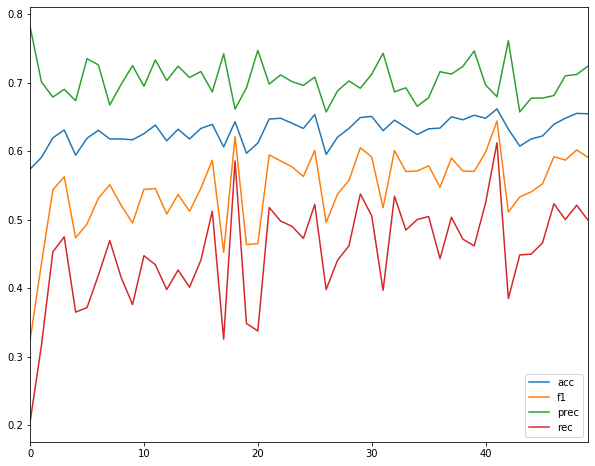

In [64]:
df_scores[['acc', 'f1', 'prec', 'rec']].plot(figsize=(10, 8))

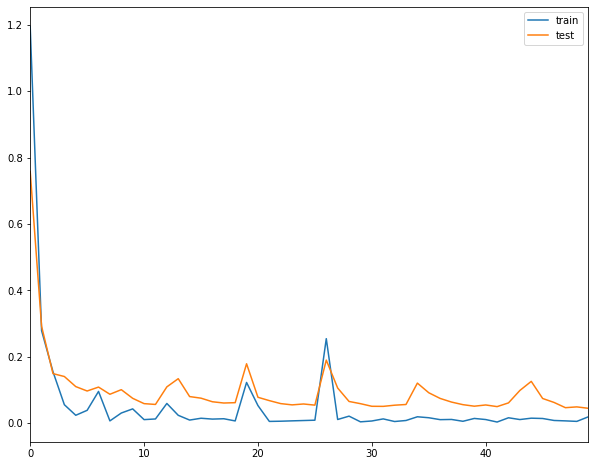

In [65]:
df_losses.plot(figsize=(10, 8))

In [66]:
df_adv_scores[df_adv_scores['labels']==0].mean()

0         1.300579
1         0.722741
2         0.481610
3         0.440187
4         0.397125
5         0.405612
6         0.435323
7         0.355329
8         0.441472
9         0.335387
10        0.320822
11        0.321402
12        0.340269
13        0.462185
14        0.373668
15        0.366334
16        0.300870
17        0.289412
18        0.289176
19        0.432503
20        0.329746
21        0.308851
22        0.327878
23        0.309482
24        0.256880
25        0.266340
26        0.567032
27        0.401075
28        0.324394
29        0.319891
30        0.316880
31        0.354388
32        0.329133
33        0.340965
34        0.427803
35        0.472908
36        0.353070
37        0.413284
38        0.280626
39        0.300708
40        0.305533
41        0.315683
42        0.349527
43        0.442854
44        0.482246
45        0.389943
46        0.353764
47        0.280421
48        0.328691
49        0.050690
labels    0.000000
dtype: float64

In [67]:
df_adv_scores[df_adv_scores['labels']==1].mean()

0         1.187013
1         0.694641
2         0.612108
3         0.641997
4         0.539458
5         0.566797
6         0.483384
7         0.455112
8         0.481317
9         0.419321
10        0.407984
11        0.325406
12        0.518339
13        0.548739
14        0.424002
15        0.352232
16        0.350809
17        0.337178
18        0.354647
19        0.482990
20        0.360636
21        0.374253
22        0.273161
23        0.317754
24        0.355740
25        0.374581
26        0.550397
27        0.560439
28        0.440007
29        0.361664
30        0.362107
31        0.341604
32        0.412823
33        0.308403
34        0.474935
35        0.452945
36        0.474579
37        0.340321
38        0.420096
39        0.354004
40        0.363476
41        0.356748
42        0.308827
43        0.503368
44        0.478697
45        0.461330
46        0.385910
47        0.408430
48        0.329886
49        0.571367
labels    1.000000
dtype: float64

## Detect adversarial instances# Detect Advs

In [68]:
ad.infer_threshold(X_train[:2000], threshold_perc=90.)

In [69]:
ad_preds = ad.predict(X_val, return_instance_score=True)

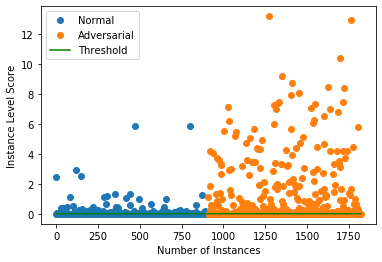

In [70]:
labels = ['Normal', 'Adversarial']
target = np.array([0 if i < X_to_adv.shape[0] else 1 for i in range(X_val.shape[0])])
plot_instance_score(ad_preds, target, labels, ad.threshold)

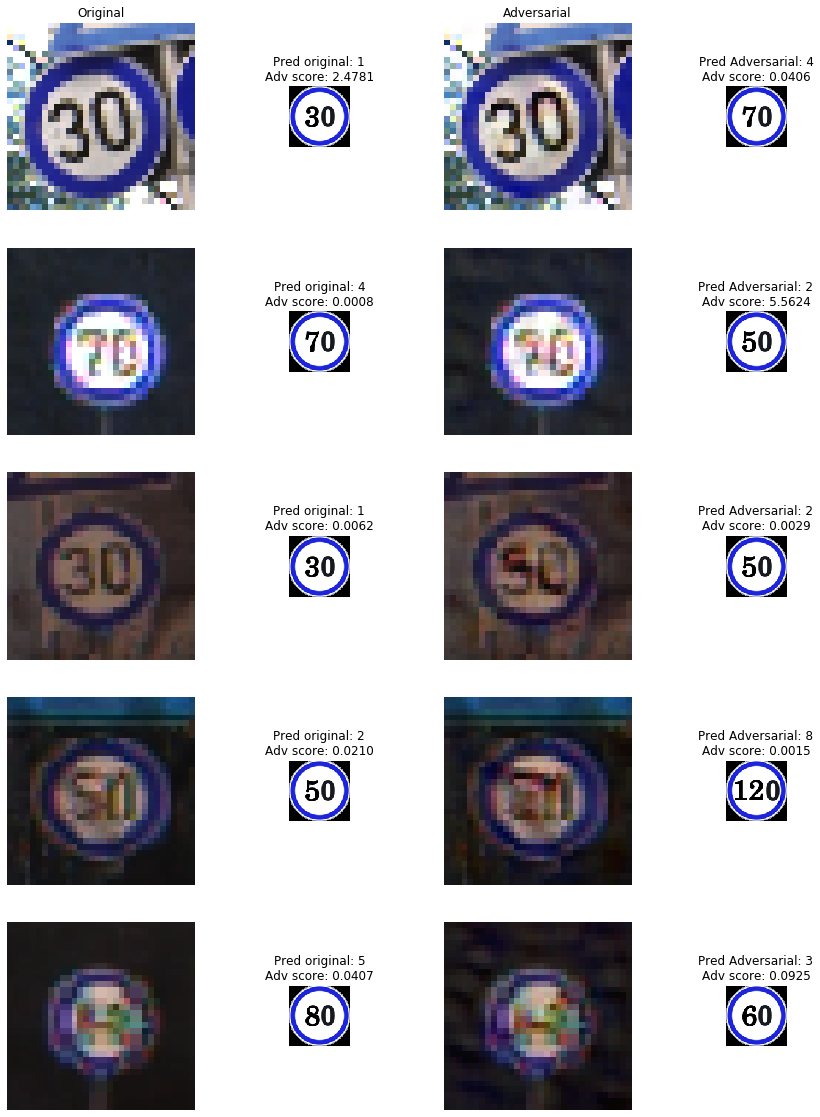

In [71]:
scores = ad_preds['data']['instance_score']
fig5 = plt.figure(constrained_layout=False, figsize=figsize)
widths = [5, 1, 5, 1]
heights = [5, 5, 5, 5, 5]
spec5 = fig5.add_gridspec(ncols=4, nrows=5, width_ratios=widths,
                          height_ratios=heights)

for row in range(n_rows):
    ax_0 = fig5.add_subplot(spec5[row, 0])    
    ax_0.imshow(X_to_adv[row].reshape(img_shape))
    if row == 0:
        ax_0.title.set_text('Original')  
    ax_0.axis('off')
    
    ax_1 = fig5.add_subplot(spec5[row, 1])
    class_image=cv2.imread(meta_folder+"{}.png".format(y_pred[row]))
    image = Image.fromarray(class_image, 'RGB')
    image = np.array(image)
    ax_1.imshow(image)
    ax_1.title.set_text('Pred original: {}'
                  '\nAdv score: {:.4f}'.format(y_pred[row], scores[row]))    
    ax_1.axis('off')
    
    ax_2 = fig5.add_subplot(spec5[row, 2])
    ax_2.imshow(X_adv[row].reshape(img_shape))
    if row == 0:
        ax_2.title.set_text('Adversarial')
    ax_2.axis('off')
    
    ax_3 = fig5.add_subplot(spec5[row, 3])
    class_image_adv=cv2.imread(meta_folder+"{}.png".format(y_pred_adv[row]))
    image_adv = Image.fromarray(class_image_adv, 'RGB')
    image_adv = np.array(image_adv)   
    ax_3.imshow(image_adv)
    ax_3.title.set_text('Pred Adversarial: {}'
                  '\nAdv score: {:.4f}'.format(y_pred_adv[row], scores[row + nb_adv]))    
    ax_3.axis('off')
        #label = 'Width: {}\nHeight: {}'.format(widths[col], heights[row])
        #ax.annotate(label, (0.1, 0.5), xycoords='axes fraction', va='center')

# Adversarial detection performances

In [72]:
kl_test_dict = ad.predict(X_to_adv, return_instance_score=True)
kl_test = kl_test_dict['data']['instance_score']
kl_adv_dict = ad.predict(X_adv, return_instance_score=True)
kl_adv = kl_adv_dict['data']['instance_score']

kl_concat = np.concatenate((kl_test, kl_adv))
tr = kl_test.shape[0]

In [73]:
print(kl_test.shape, kl_adv.shape)
print(kl_test.mean(), kl_test.std())
print(kl_adv.mean(), kl_adv.std())

(910,) (910,)
0.05340349 0.34295756
0.57353354 1.5909607


In [74]:
preds_ad_test = kl_test_dict['data']['is_adversarial']
preds_ad_adv = kl_adv_dict['data']['is_adversarial']
preds_ad = np.concatenate((preds_ad_test, preds_ad_adv))
y_true_ad = np.concatenate((np.zeros(len(preds_ad_test)), np.ones(len(preds_ad_adv))))

In [75]:
print('Adversarial detection accuracy:', accuracy_score(y_true_ad, preds_ad))

Adversarial detection accuracy: 0.6467032967032967


In [76]:
print('Adversarial detection f1:', f1_score(y_true_ad, preds_ad))

Adversarial detection f1: 0.5766951942067149


## Curves

In [77]:
def predict_adv(x, tr):
    return (x > tr).astype(int)

def _calculate_perc(df_t, nb_sigmas=3):
    sigma_plus = df_t['test'].mean() + (nb_sigmas * df_t['test'].std())
    pc_sigma = percentileofscore(df_t['adv'], sigma_plus) * 0.01
    perc = 1 - pc_sigma
    return perc, sigma_plus

def calculate_perc_nn(X_train, X_test, X_test_adv, predict_fn, nb_samples=100, nb_sigmas=3):
    
    X_train_samples = np.random.permutation(X_train)[:nb_samples]
    preds_train = predict_fn(X_train_samples)
    nn = NearestNeighbors()
    nn.fit(preds_train)
    
    preds_test, preds_adv = predict_fn(X_test), predict_fn(X_test_adv)
    dist_test, idx_test = nn.kneighbors(preds_test, n_neighbors=1)
    dist_adv, idx_adv = nn.kneighbors(preds_adv, n_neighbors=1)

    df_dist = pd.DataFrame()
    df_dist['test'] = dist_test.flatten()
    df_dist['adv'] = dist_adv.flatten()
    
    perc, sigma_plus = _calculate_perc(df_dist, nb_sigmas=nb_sigmas)
    
    return perc, df_dist, sigma_plus

def predict_fn(x):
    return model.predict(x)

In [78]:
perm = np.random.permutation(range(len(kl_adv)))[:500]
x_kl = np.concatenate((kl_test, kl_adv[perm]))
y_kl = np.concatenate((np.zeros(len(kl_test)), np.ones(len(kl_adv[perm]))))
x_kl = x_kl / x_kl.max()

In [79]:
perc, df_dist, sigma_plus = calculate_perc_nn(X_train, X_to_adv, X_adv, predict_fn, nb_samples=1000, nb_sigmas=5)
dist_test, dist_adv = df_dist['test'].values, df_dist['adv'].values
x_bl =  np.concatenate((dist_test, dist_adv[perm]))
y_bl = np.concatenate((np.zeros(len(dist_test)), np.ones(len(dist_adv[perm]))))
x_bl = x_bl / x_bl.max()

### Precision recall curves

Naive detector baseline


(0.0, 1.0)

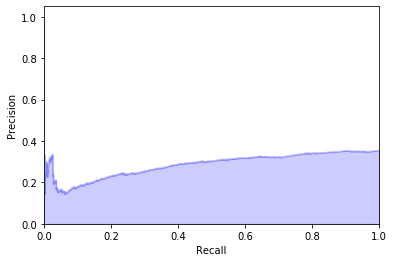

In [80]:
print('Naive detector baseline')
precision_bl, recall_bl, thresholds_bl = precision_recall_curve(y_bl, x_bl)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall_bl, precision_bl, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall_bl, precision_bl, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

Vae detector


(0.0, 1.0)

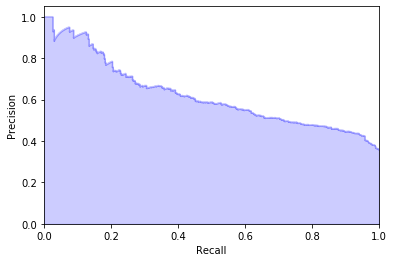

In [82]:
print('Vae detector')
precision, recall, thresholds = precision_recall_curve(y_kl, x_kl)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

### Accuracy - f1 scores

In [83]:
trs = np.arange(0, 1.001, 0.001)
tresholds, precs, recals, accs, f1s = [], [], [], [], []
precs_bl, recals_bl, accs_bl, f1s_bl = [], [], [], []
for tr in trs:
    preds_kl = predict_adv(x_kl, tr)
    preds_bl = predict_adv(x_bl, tr)
    
    prec = precision_score(y_kl, preds_kl)
    rec = recall_score(y_kl, preds_kl)
    acc = accuracy_score(y_kl, preds_kl)
    f1 = f1_score(y_kl, preds_kl)
    
    prec_bl = precision_score(y_bl, preds_bl)
    rec_bl = recall_score(y_bl, preds_bl)
    acc_bl = accuracy_score(y_bl, preds_bl)
    f1_bl = f1_score(y_bl, preds_bl)
    
    tresholds.append(tr)
    precs.append(prec)
    recals.append(rec)
    accs.append(acc)
    f1s.append(f1)
    
    precs_bl.append(prec_bl)
    recals_bl.append(rec_bl)
    accs_bl.append(acc_bl)
    f1s_bl.append(f1_bl)

df_scores = pd.DataFrame()
df_scores['trs'] = tresholds
df_scores['precs'] = precs
df_scores['recs'] = recals
df_scores['accs'] = accs
df_scores['f1s'] = f1s

df_scores['precs_bl'] = precs_bl
df_scores['recs_bl'] = recals_bl
df_scores['accs_bl'] = accs_bl
df_scores['f1s_bl'] = f1s_bl

/home/gio/anaconda3/envs/tf2-gpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gio/anaconda3/envs/tf2-gpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy


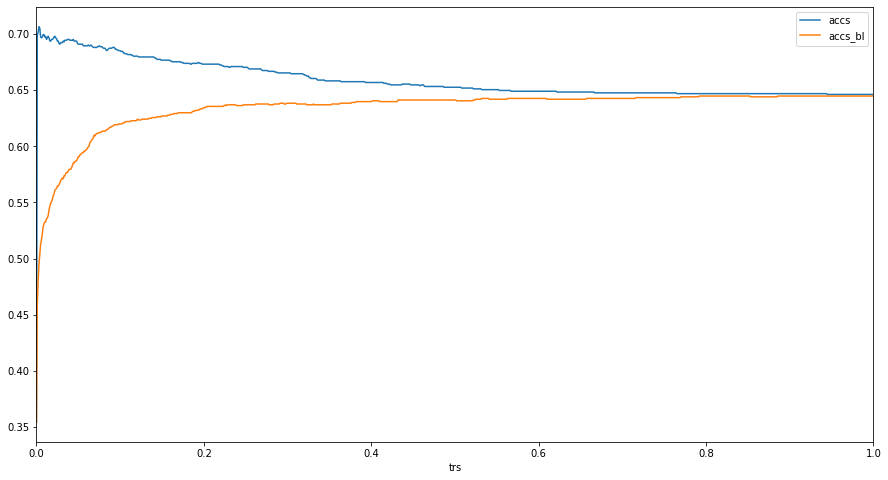

In [84]:
print('Accuracy')
df_scores.plot(x= 'trs',y=['accs', 'accs_bl'], figsize=(15, 8))

F1 score


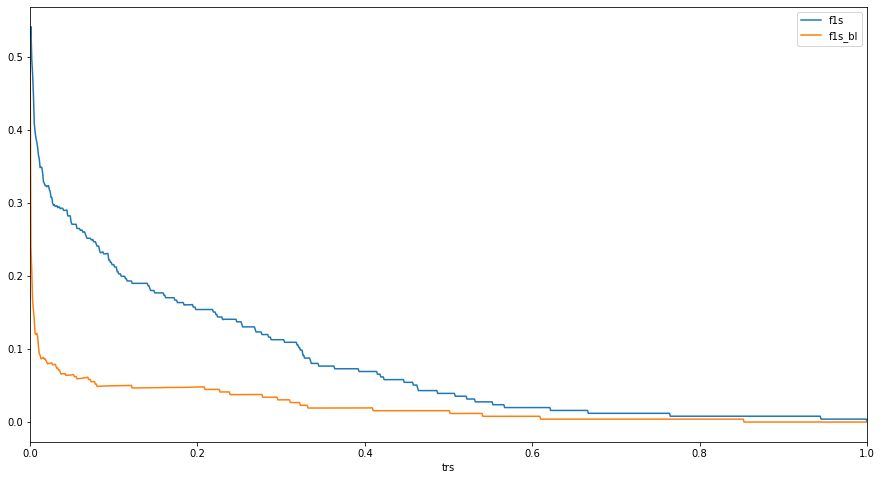

In [85]:
print('F1 score')
df_scores.plot(x= 'trs',y=['f1s', 'f1s_bl'], figsize=(15, 8))

In [86]:
df_scores.describe()

,trs,precs,recs,accs,f1s,precs_bl,recs_bl,accs_bl,f1s_bl
count,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000
mean,0.500000,0.951298,0.046705,0.658838,0.081001,0.208882,0.013528,0.633855,0.022176
std,0.289108,0.073201,0.065442,0.017764,0.092664,0.101673,0.035948,0.022846,0.029596
min,0.000000,0.000000,0.000000,0.354610,0.000000,0.000000,0.000000,0.354610,0.000000
25%,0.250000,0.913793,0.006000,0.647518,0.011928,0.166667,0.002000,0.636879,0.003953
50%,0.500000,1.000000,0.020000,0.652482,0.039216,0.233333,0.008000,0.641135,0.015504
75%,0.750000,1.000000,0.074000,0.670213,0.137291,0.285714,0.020000,0.643262,0.037665
max,1.000000,1.000000,1.000000,0.706383,0.541532,0.354610,1.000000,0.645390,0.523560


### Distributions

Vae detector


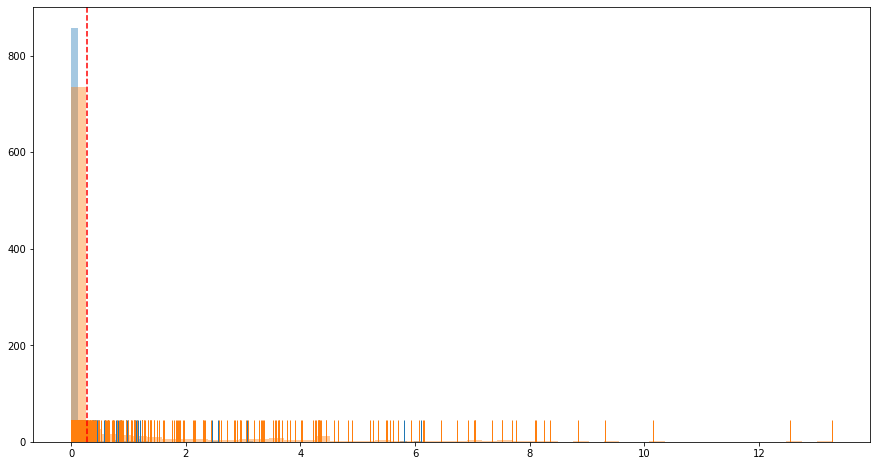

In [87]:
print('Vae detector')
fig, ax = plt.subplots(figsize=(15, 8))
sns.distplot(kl_test, rug=True, ax=ax, kde=False)
plt.axvline(sigma_plus, c='r', linestyle='dashed')
sns.distplot(kl_adv, rug=True,ax=ax, kde=False)

Naive detector baseline


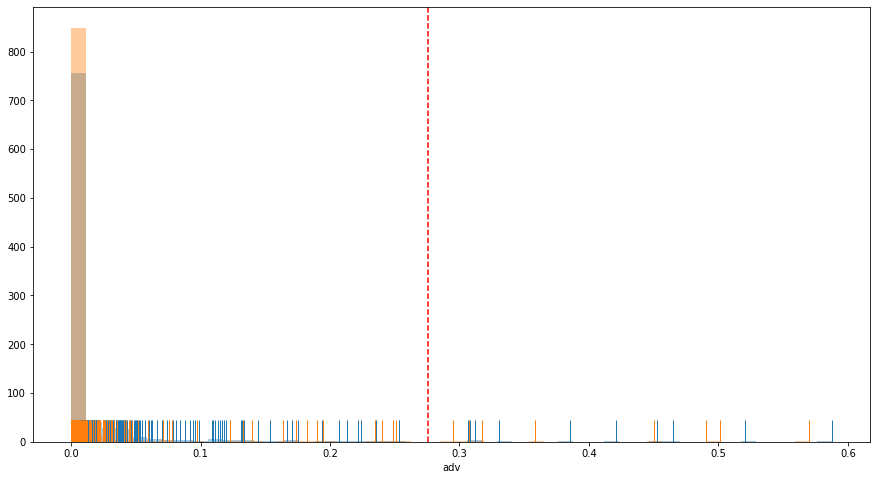

In [88]:
print('Naive detector baseline')
fig, ax = plt.subplots(figsize=(15, 8))
sns.distplot(df_dist['test'], rug=True, ax=ax, kde=False)
plt.axvline(sigma_plus, c='r', linestyle='dashed')
sns.distplot(df_dist['adv'], rug=True,ax=ax, kde=False)